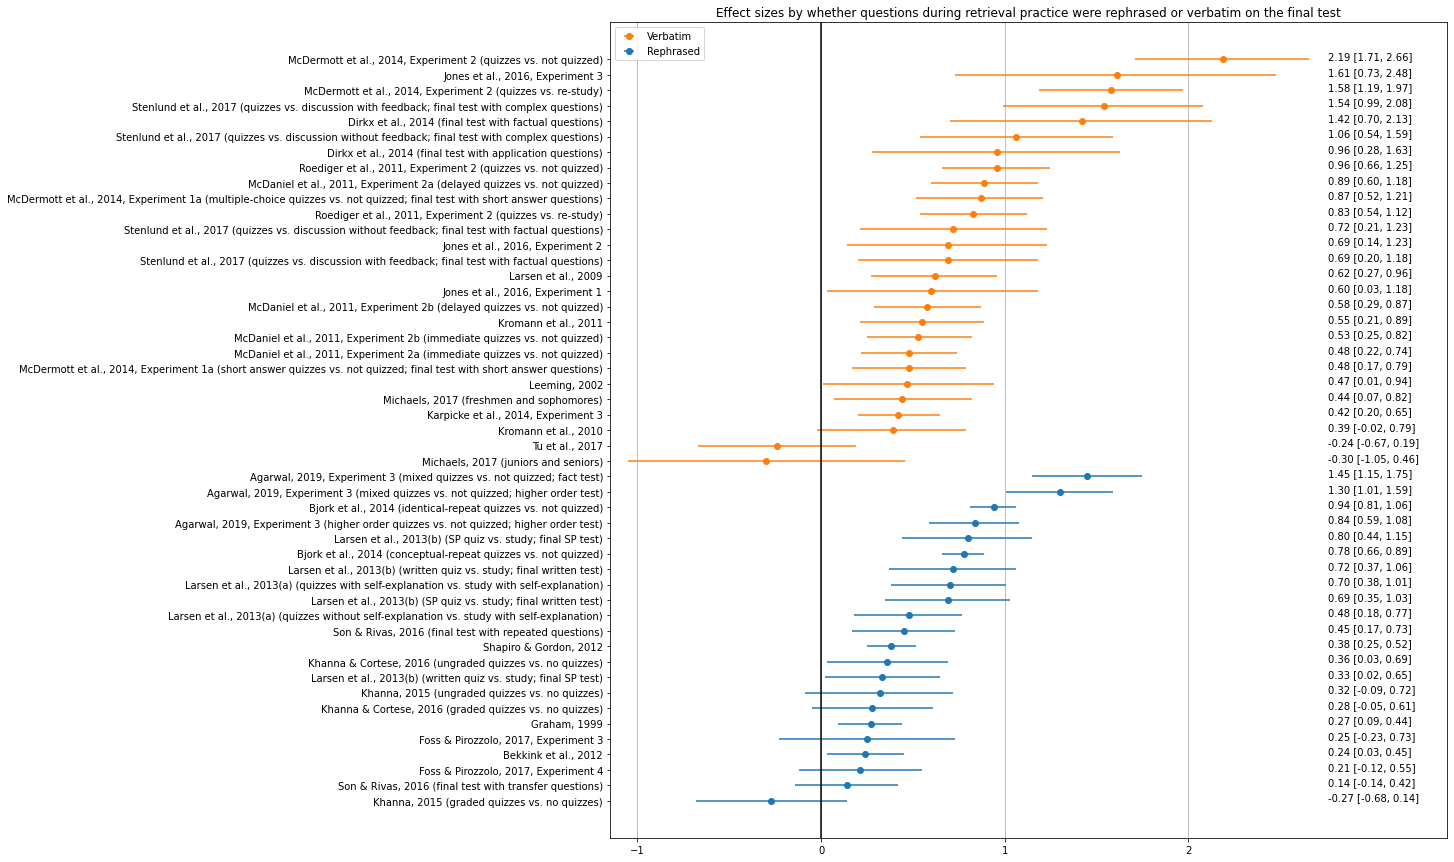

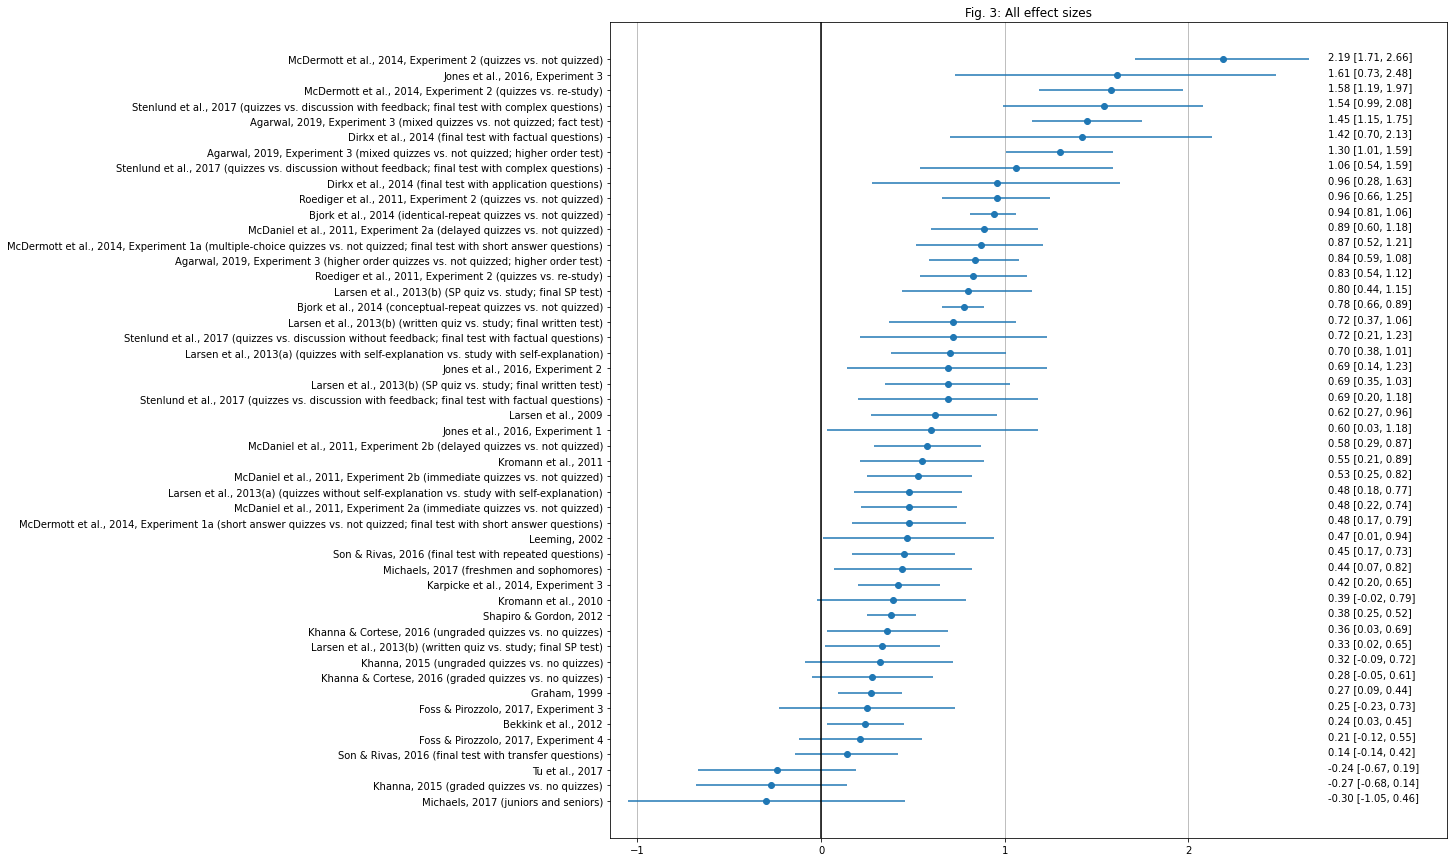

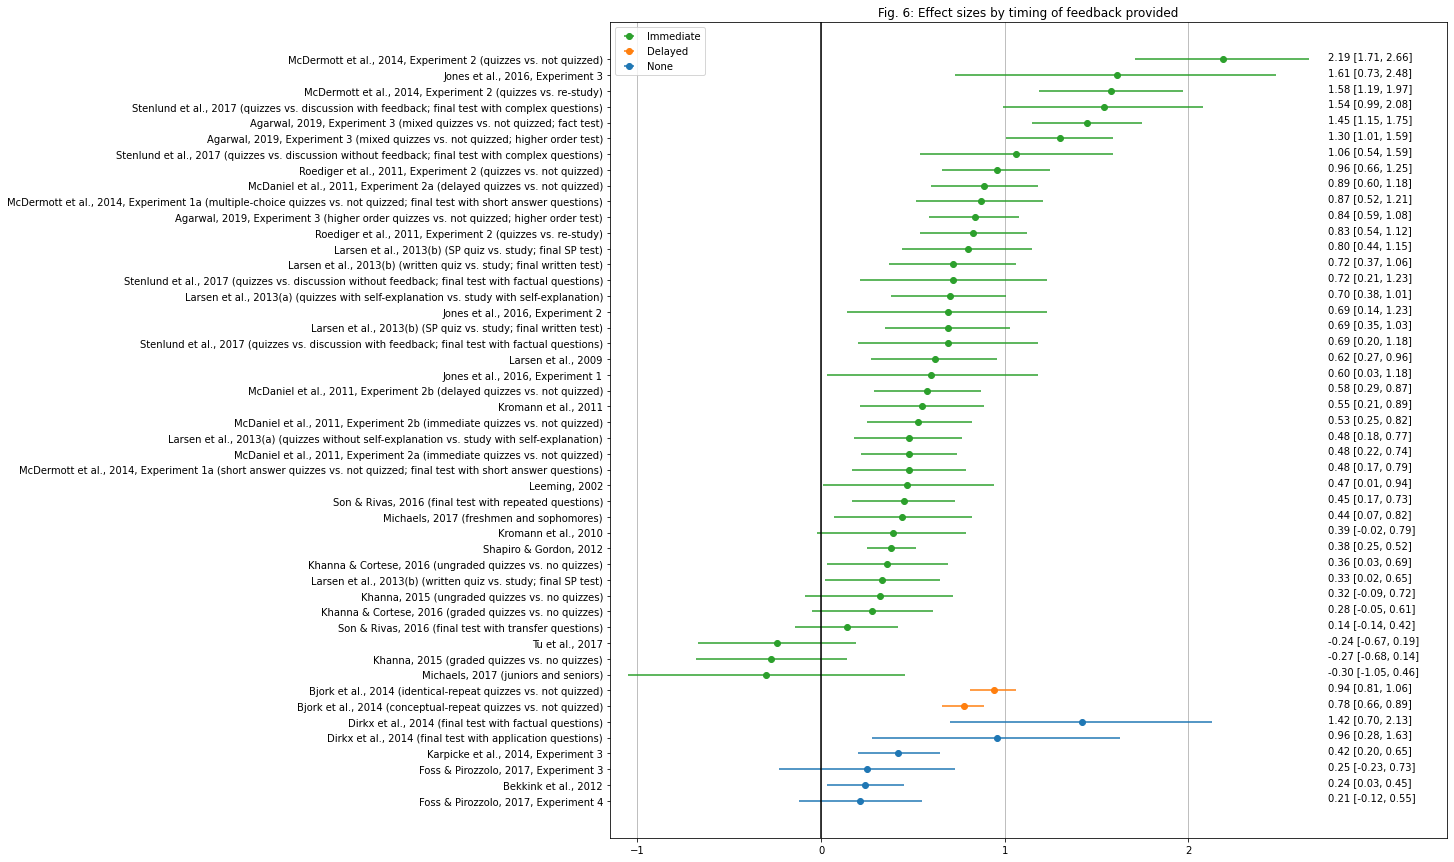

In [69]:
# Plot data from the paper "Retrieval Practice Consistently Benefits Student Learning: a Systematic Review of Applied Research in Schools and Classrooms"
# 
# The purpose of this notebook is to recreate the forest plots shown in the paper.
# It has access to the paper's data so it can be used to create additional forest
# plots that weren't included in the paper. For example, the notebook includes an
# additional plot that groups experiments based on whether the questions used
# during retrieval practice appeared as rephrased or verbatim on the final test
# (see `plot_by_is_final_test_rephrased()`). Andy Matuschak expressed interest
# in this plot when doing a reading of this paper over a livestream (https://youtu.be/kG2_6ToMZgI?t=3860).
#
# Links:
#   - paper: https://rdcu.be/cgITe
#   - data:
#     - Spreadsheet: http://bit.ly/retrievalpracticereview
#     - Open Science Framework: https://osf.io/mz2ks/

import itertools
import json
import math
import matplotlib.pyplot as plt

# Constants for field names
INDEX = 0
SHORT_CITATION = 1
FULL_CITATION = 2
PUBLICATION_YEAR = 3
INTERVENTION = 4
SPECIFIC_COMPARISON_CONDITIONS = 5
OVERALL_TYPE_OF_COMPARISON_CONDITIONS = 6
EFFECT_SIZES = 7
EDUCATION_LEVEL = 8
CONTENT_AREA = 9
COURSE_TOPIC = 10
EXPERIMENTAL_DESIGN = 11
SAMPLE_SIZE = 12
CONDUCTED_IN_THE_US = 13
RETRIEVAL_PRACTICE_TIMING = 14
DELAY_BETWEEN_LAST_RETRIEVAL_PRACTICE_AND_FINAL_TEST = 15
RETRIEVAL_PRACTICE_FORMAT = 16
FEEDBACK_AFTER_RETRIEVAL_PRACTICE = 17
FINAL_TEST_FORMAT = 18
FINAL_TEST_COUNTED_TOWARDS_STUDENTS_GRADE = 19

# Example:
#   - Input: "1.45 [1.15, 1.75] (mixed quizzes vs. not quizzed; fact test)"
#   - Output: {"label": "mixed quizzes vs. not quizzed; fact test", "effect_size": 1.45, "lower": 1.15, "upper": 1.75}
def parse_effect_size_string(effect_size_string):
    s = effect_size_string
    effect_size = float(s[0:s.index(" ")])
    lower = float(s[s.index("[")+1:s.index(",")])
    upper = float(s[s.index(",")+1:s.index("]")])
    label = s[s.index("(")+1:-1] if ("(" in s) else None
    
    return {"label": label, "effect_size": effect_size, "lower": lower, "upper": upper}

def parse_effect_sizes(entry):
    lines = entry.split("\n")
    lines = map(lambda line: line.strip(" \r\n\t"), lines)
    lines = filter(lambda line: line != "" and (line[0].isdigit() or line[0] == "-"), lines)
    lines = map(lambda line: parse_effect_size_string(line), lines)
    return list(lines)

with open("data.json", "r") as f:
    headers_and_data = json.loads(f.read())

headers = headers_and_data[0]
data = headers_and_data[1:]

def is_final_test_rephrased(entry):
    return "*" in entry[FINAL_TEST_FORMAT]

all_experiments = []
for paper in data:
    for experiment in parse_effect_sizes(paper[EFFECT_SIZES]):
        experiment["paper"] = paper[SHORT_CITATION]
        experiment["is_final_test_rephrased"] = is_final_test_rephrased(paper)
        experiment["feedback"] = paper[FEEDBACK_AFTER_RETRIEVAL_PRACTICE]
        all_experiments.append(experiment)
all_experiments = sorted(all_experiments, key=lambda d: -d["effect_size"])

def get_experiment_label(experiment):
    full_label = experiment["paper"]
    if experiment["label"]:
        full_label += " (" + experiment["label"] + ")"
    return full_label

def fmt_float(f):
    return "{:.2f}".format(f)

def fmt_effect_size(experiment):
    return fmt_float(experiment["effect_size"]) + " [" + fmt_float(experiment["lower"]) + ", " + fmt_float(experiment["upper"]) + "]"

def fmt_experiment(experiment):
    return (
        get_experiment_label(experiment).ljust(130) +
        fmt_effect_size(experiment)
    )

def dump_experiments():
    return [fmt_experiment(experiment) for experiment in all_experiments]

def group_by(lst, keyfn):
    result = {}
    for item in lst:
        key = keyfn(item)
        if not (key in result):
            result[key] = []
        result[key].append(item)
    return result

def select_keys(keys, d):
    return list(map(lambda key: [key, d[key]], keys))

def select_all_keys(d):
    return [[key, value] for key, value in d.items()]

def plot_group(ax, max_x, title, experiments):
    experiments = list(reversed(experiments))
    xs = [experiment["effect_size"] for experiment in experiments]
    ys = [get_experiment_label(experiment) for experiment in experiments]
    lower_errors = [(experiment["effect_size"] - experiment["lower"]) for experiment in experiments]
    upper_errors = [(experiment["upper"] - experiment["effect_size"]) for experiment in experiments]
    
    ax.errorbar(xs, ys, xerr=[lower_errors, upper_errors], fmt='o', label=title)
    
    for experiment, y in zip(experiments, ys):
       ax.annotate(fmt_effect_size(experiment), xy=(max_x, y))

def plot_groups(plot_title, groups):
    groups = list(reversed(groups))
    
    all_experiments = list(itertools.chain(*[experiments for _, experiments in groups]))
    # Subtract 0.1 to leave some room between the first point and the beginning of the plot.
    min_x = min(all_experiments, key=lambda entry: entry["lower"])["lower"] - 0.1
    # Add 0.1 to leave some room between the last point and the end of the plot.
    max_x = max(all_experiments, key=lambda entry: entry["upper"])["upper"] + 0.1
    
    plt.figure(figsize=(15, 15))
    ax = plt.gca()
    
    for title, experiments in groups:
        plot_group(ax, max_x, title, experiments)
    
    if len(groups) > 1:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels), loc='upper left')
    ax.set_title(plot_title)
    ax.axvline(0, color='black')
    # Add 0.65 to leave some room at the end of the plot to render an effect size
    # label for each line.
    ax.set_xlim(min_x, max_x + 0.65)
    ax.set_xticks(range(int(min_x), int(max_x) + 1))
    plt.grid(axis='x')
    plt.show()
    
#
# Plots
#

# This forest plot isn't included in the paper
def plot_by_is_final_test_rephrased():
    plot_groups('Effect sizes by whether questions during retrieval practice were rephrased or verbatim on the final test',
                select_all_keys(group_by(all_experiments, lambda exp: "Rephrased" if exp["is_final_test_rephrased"] else "Verbatim")))

# Similar to Fig. 3 in the paper
def plot_flat():
    plot_groups('Fig. 3: All effect sizes',
                [[None, all_experiments]])
    
# Similar to Fig. 6 in the paper
def plot_by_feedback():
  plot_groups('Fig. 6: Effect sizes by timing of feedback provided',
              select_keys(['Immediate', 'Delayed', 'None'],
                          group_by(all_experiments, lambda exp: exp["feedback"])))

# dump_experiments()
    
plot_by_is_final_test_rephrased()
plot_flat()
plot_by_feedback()